In [2]:
import sys 

pathScripts = '../COMPAS/utils/CosmicIntegration' 

sys.path.append(pathScripts) 

In [21]:
import os, sys
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import matplotlib.gridspec as gridspec
from matplotlib import rc
import astropy.units as u
from   astropy.cosmology import WMAP9 as cosmology
from scipy import stats
from   scipy.optimize import newton
import warnings

import h5py as h5 

import ClassCOMPAS, ClassMSSFR, ClassCosmicIntegrator 
import FastCosmicIntegration as FCI 
import selection_effects

In [28]:
#Set latex environment for plots/labels
import matplotlib
matplotlib.rc('font', **{'family': 'serif'})
matplotlib.rc('text', usetex=False)
matplotlib.rcParams['text.latex.preamble'] = [r'\boldmath']
plt.rcParams.update({'font.family':'serif'})


fl=22
fm=18
fs=16
import seaborn as sns
sns.set_style("white")

In [48]:
# this is just a little function that we will use to make the plot more beautiful (bigger ticks, labels)
# However, you do not have to use this (just uncommoment "layoutAxes" everywhere)
from matplotlib.ticker import (FormatStrFormatter,
                               AutoMinorLocator)

def layoutAxes(ax, nameX='', nameY='', \
               labelSizeMajor = 10, fontsize = fm, second=False, labelpad=None, setMinor=True):
    matplotlib.rc('font', **{'family': 'serif'})

    """
    Tiny code to do the layout for axes in matplotlib
    """
    tickLengthMajor = 10
    tickLengthMinor = 5
    tickWidthMajor  = 1.5
    tickWidthMinor  = 1.5
    
    #rc('axes', linewidth=2)
    #label1 always refers to first axis not the twin 
    if not second:
        for tick in ax.xaxis.get_major_ticks():
            tick.label1.set_fontsize(fontsize)
            #tick.label1.set_fontweight('bold')
        for tick in ax.yaxis.get_major_ticks():
            tick.label1.set_fontsize(fontsize)
            #tick.label1.set_fontweight('bold')
    if second:
        for tick in ax.xaxis.get_major_ticks():
            tick.label2.set_fontsize(fontsize)
            #tick.label1.set_fontweight('bold')
        for tick in ax.yaxis.get_major_ticks():
            tick.label2.set_fontsize(fontsize)
            #tick.label1.set_fontweight('bold')
    for axis in ['top','bottom','left','right']:
        ax.spines[axis].set_linewidth(1.2)
    ax.tick_params(length=tickLengthMajor, width=tickWidthMajor, which='major')
    ax.tick_params(length=tickLengthMinor, width=tickWidthMinor, which='minor')
    ax.set_xlabel(nameX, fontsize=fontsize,labelpad=labelpad)#,fontweight='bold')
    ax.set_ylabel(nameY, fontsize=fontsize,labelpad=labelpad)#, fontweight='bold')    
    
    if setMinor==True:
        # add minor ticks:
        ax.xaxis.set_minor_locator(AutoMinorLocator())
        ax.yaxis.set_minor_locator(AutoMinorLocator())

    return ax


In [5]:
bh_kick = 200
ns_kick = 500
sigma = 0.4

hobbs_pathData        = os.environ['WORK']+f'/supernova_remnant_det/hobbs_det_combined.h5'
mm_pathData        = os.environ['WORK'] + f"/supernova_remnant_det/mullermandel_ns_{ns_kick}_sigma_{sigma}_det_combined.h5"


# pathData        = os.environ['WORK'] + f'/supernova_remnant_bse/bh_{bh_kick}_ns_{ns_kick}_sigma_{sigma}_combined.h5'


In [6]:
# First define the parameters

# For what DCO would you like the rate?  options: ALL, BHBH, BHNS NSNS
dco_type        = "BBH"
weight_column   = None
                        
merges_hubble_time     = True
pessimistic_CEE        = True
no_RLOF_after_CEE      = True

# Options for the redshift evolution 
max_redshift           = 10.0
max_redshift_detection = 2.0
redshift_step          = 0.001
z_first_SF             = 10

# Metallicity of the Universe
min_logZ               = -12.0 
max_logZ               = 0.0 
step_logZ              = 0.01

#and detector sensitivity
sensitivity            = "O1" 
snr_threshold          = 8 

Mc_max                 = 300.0 
Mc_step                = 0.1 
eta_max                = 0.25 
eta_step               = 0.01
snr_max                = 1000.0 
snr_step               = 0.1

# Parameters to calculate the representing SF mass (make sure these match YOUR simulation!)
m1_min          = 5 * u.Msun 
m1_max          = 150 * u.Msun
m2_min          = 0.1 * u.Msun
fbin            = 0.7

# Parameters determining dP/dZ and SFR(z), default options from Neijssel 2019
aSF             = 0.01 
bSF             = 2.77 
cSF             = 2.90 
dSF             = 4.70
#
mu0             = 0.035 
muz             = -0.23 
sigma0          = 0.39
sigmaz          = 0. 
alpha           = 0.0 

# Hobbs

In [7]:
hobbs_detection_rate, hobbs_formation_rate, hobbs_merger_rate, hobbs_redshifts, hobbs_COMPAS = FCI.find_detection_rate(
    hobbs_pathData, dco_type=dco_type, weight_column=weight_column,
    merges_hubble_time=merges_hubble_time, pessimistic_CEE=pessimistic_CEE,
    no_RLOF_after_CEE=no_RLOF_after_CEE, max_redshift=max_redshift,
    max_redshift_detection=max_redshift_detection,
    redshift_step=redshift_step, z_first_SF=z_first_SF,
    m1_min=m1_min, m1_max=m1_max, m2_min=m2_min,
    fbin=fbin, aSF=aSF, bSF=bSF, cSF=cSF, dSF=dSF,
    mu0=mu0, muz=muz, sigma0=sigma0, alpha=alpha,
    min_logZ=min_logZ, max_logZ=max_logZ, step_logZ=step_logZ,
    sensitivity=sensitivity, snr_threshold=snr_threshold,
    Mc_max=Mc_max, Mc_step=Mc_step,
    eta_max=eta_max, eta_step=eta_step,
    snr_max=snr_max, snr_step=snr_step)

/opt/apps/intel19/python3/3.7.0/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: Maximum chirp mass used for detectability calculation is below maximum binary chirp mass * (1+maximum redshift for detectability calculation)
  


Average_SF_mass_needed =  1017706143.5049736 solMass


In [8]:
hobbs_chirp_masses = (hobbs_COMPAS.mass1*hobbs_COMPAS.mass2)**(3./5.) / (hobbs_COMPAS.mass1 + hobbs_COMPAS.mass2)**(1./5.)

# sum things up across binaries
hobbs_total_formation_rate = np.sum(hobbs_formation_rate, axis=0)
hobbs_total_merger_rate = np.sum(hobbs_merger_rate, axis=0)
hobbs_total_detection_rate = np.sum(hobbs_detection_rate, axis=0)

# and across redshifts
hobbs_cumulative_detection_rate = np.cumsum(hobbs_total_detection_rate)
hobbs_detection_rate_by_binary = np.sum(hobbs_detection_rate, axis=1)

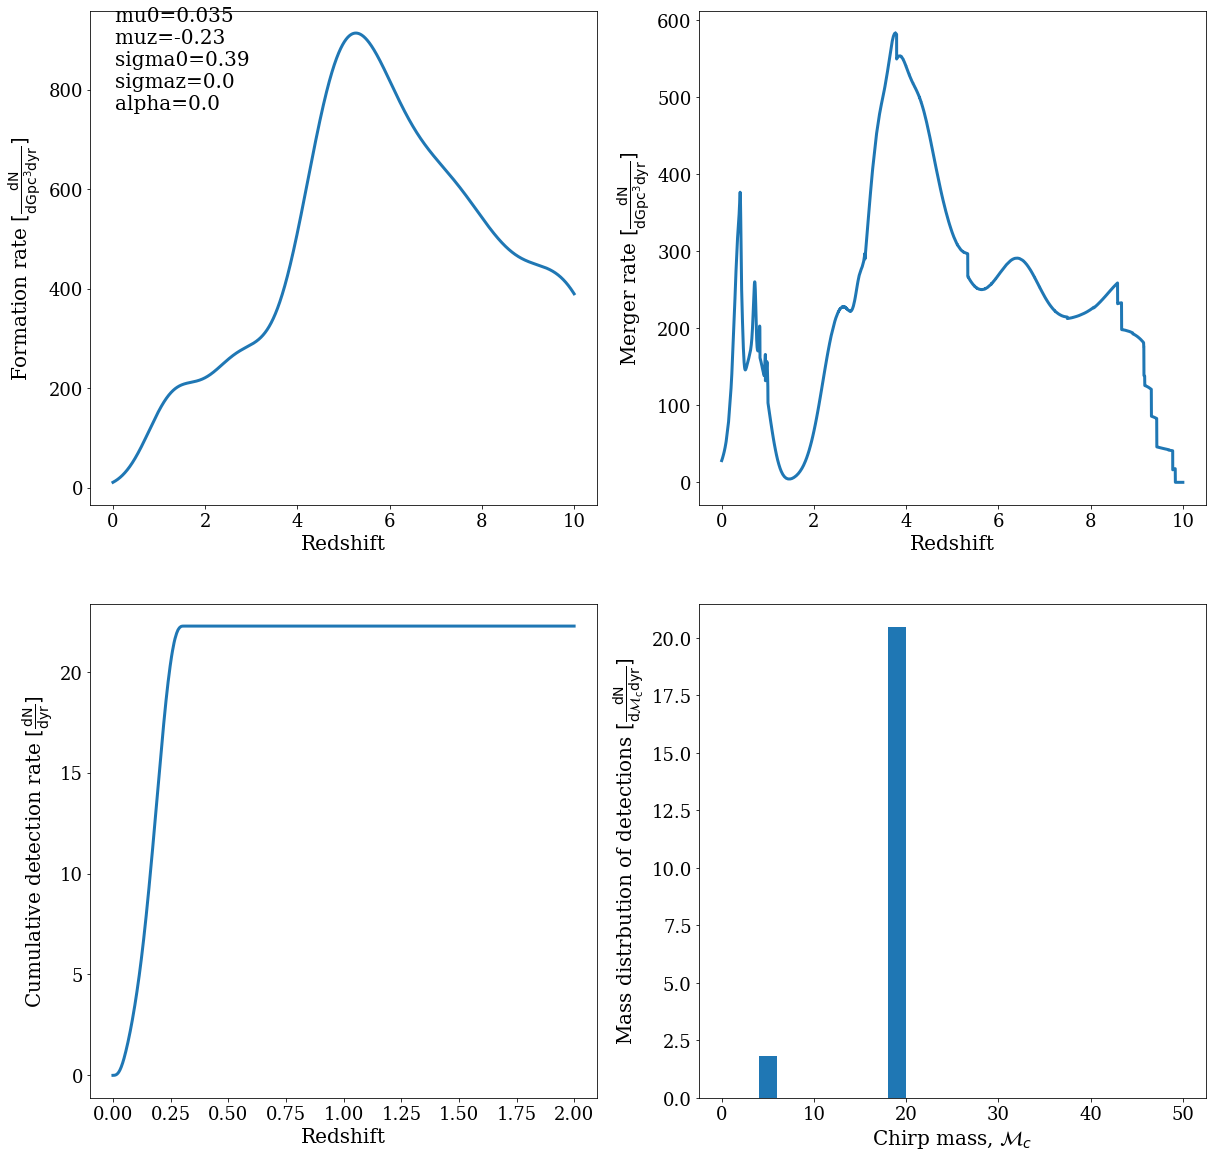

In [9]:
###########################
#Start plotting

# set some constants for the plots
plt.rc('font', family='serif')
fs = 20
lw = 3

fig, axes = plt.subplots(2, 2, figsize=(20, 20))

axes[0,0].plot(hobbs_redshifts, hobbs_total_formation_rate, lw=lw)
axes[0,0].set_xlabel('Redshift', fontsize=fs)
axes[0,0].set_ylabel(r'Formation rate $[\rm \frac{\mathrm{d}N}{\mathrm{d}Gpc^3 \mathrm{d}yr}]$', fontsize=fs)

axes[0,1].plot(hobbs_redshifts, hobbs_total_merger_rate, lw=lw)
axes[0,1].set_xlabel('Redshift', fontsize=fs)
axes[0,1].set_ylabel(r'Merger rate $[\rm \frac{\mathrm{d}N}{\mathrm{d}Gpc^3 \mathrm{d}yr}]$', fontsize=fs)

axes[1,0].plot(hobbs_redshifts[:len(hobbs_cumulative_detection_rate)], hobbs_cumulative_detection_rate, lw=lw)
axes[1,0].set_xlabel('Redshift', fontsize=fs)
axes[1,0].set_ylabel(r'Cumulative detection rate $[\rm \frac{\mathrm{d}N}{\mathrm{d}yr}]$', fontsize=fs)

axes[1,1].hist(hobbs_chirp_masses, weights=hobbs_detection_rate_by_binary, bins=25, range=(0, 50))
axes[1,1].set_xlabel(r'Chirp mass, $\mathcal{M}_c$', fontsize=fs)
axes[1,1].set_ylabel(r'Mass distrbution of detections $[\rm \frac{\mathrm{d}N}{\mathrm{d}\mathcal{M}_c \mathrm{d}yr}]$', fontsize=fs)

#########################
#Plotvalues

# Add text upper left corner
axes[0,0].text(0.05,0.8, 
        "mu0={} \nmuz={} \nsigma0={} \nsigmaz={} \nalpha={}".format(mu0,muz,sigma0,sigmaz,alpha), 
        transform=axes[0,0].transAxes, size = fs) 

for ax in axes.flatten():
    ax.tick_params(labelsize=0.9*fs)

# Save and show :)
# plt.savefig(imageDir + "RateInfoHist_mu0{}_muz{}_alpha{}_sigma0{}_sigmaz{}.png".format(mu0, muz, alpha, sigma0, sigmaz), bbox_inches='tight') 


In [10]:
hobbs_total_merger_rate

array([28.19796739, 28.34057079, 28.57437653, ...,  0.        ,
        0.        ,  0.        ])

# MullerMandel

In [11]:
mm_detection_rate, mm_formation_rate, mm_merger_rate, mm_redshifts, mm_COMPAS = FCI.find_detection_rate(
    mm_pathData, dco_type=dco_type, weight_column=weight_column,
    merges_hubble_time=merges_hubble_time, pessimistic_CEE=pessimistic_CEE,
    no_RLOF_after_CEE=no_RLOF_after_CEE, max_redshift=max_redshift,
    max_redshift_detection=max_redshift_detection,
    redshift_step=redshift_step, z_first_SF=z_first_SF,
    m1_min=m1_min, m1_max=m1_max, m2_min=m2_min,
    fbin=fbin, aSF=aSF, bSF=bSF, cSF=cSF, dSF=dSF,
    mu0=mu0, muz=muz, sigma0=sigma0, alpha=alpha,
    min_logZ=min_logZ, max_logZ=max_logZ, step_logZ=step_logZ,
    sensitivity=sensitivity, snr_threshold=snr_threshold,
    Mc_max=Mc_max, Mc_step=Mc_step,
    eta_max=eta_max, eta_step=eta_step,
    snr_max=snr_max, snr_step=snr_step)


/opt/apps/intel19/python3/3.7.0/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: Maximum chirp mass used for detectability calculation is below maximum binary chirp mass * (1+maximum redshift for detectability calculation)
  


Average_SF_mass_needed =  1015800133.8012469 solMass


In [12]:
mm_chirp_masses = (mm_COMPAS.mass1*mm_COMPAS.mass2)**(3./5.) / (mm_COMPAS.mass1 + mm_COMPAS.mass2)**(1./5.)

# sum things up across binaries
mm_total_formation_rate = np.sum(mm_formation_rate, axis=0)
mm_total_merger_rate = np.sum(mm_merger_rate, axis=0)
mm_total_detection_rate = np.sum(mm_detection_rate, axis=0)

# and across redshifts
mm_cumulative_detection_rate = np.cumsum(mm_total_detection_rate)
mm_detection_rate_by_binary = np.sum(mm_detection_rate, axis=1)

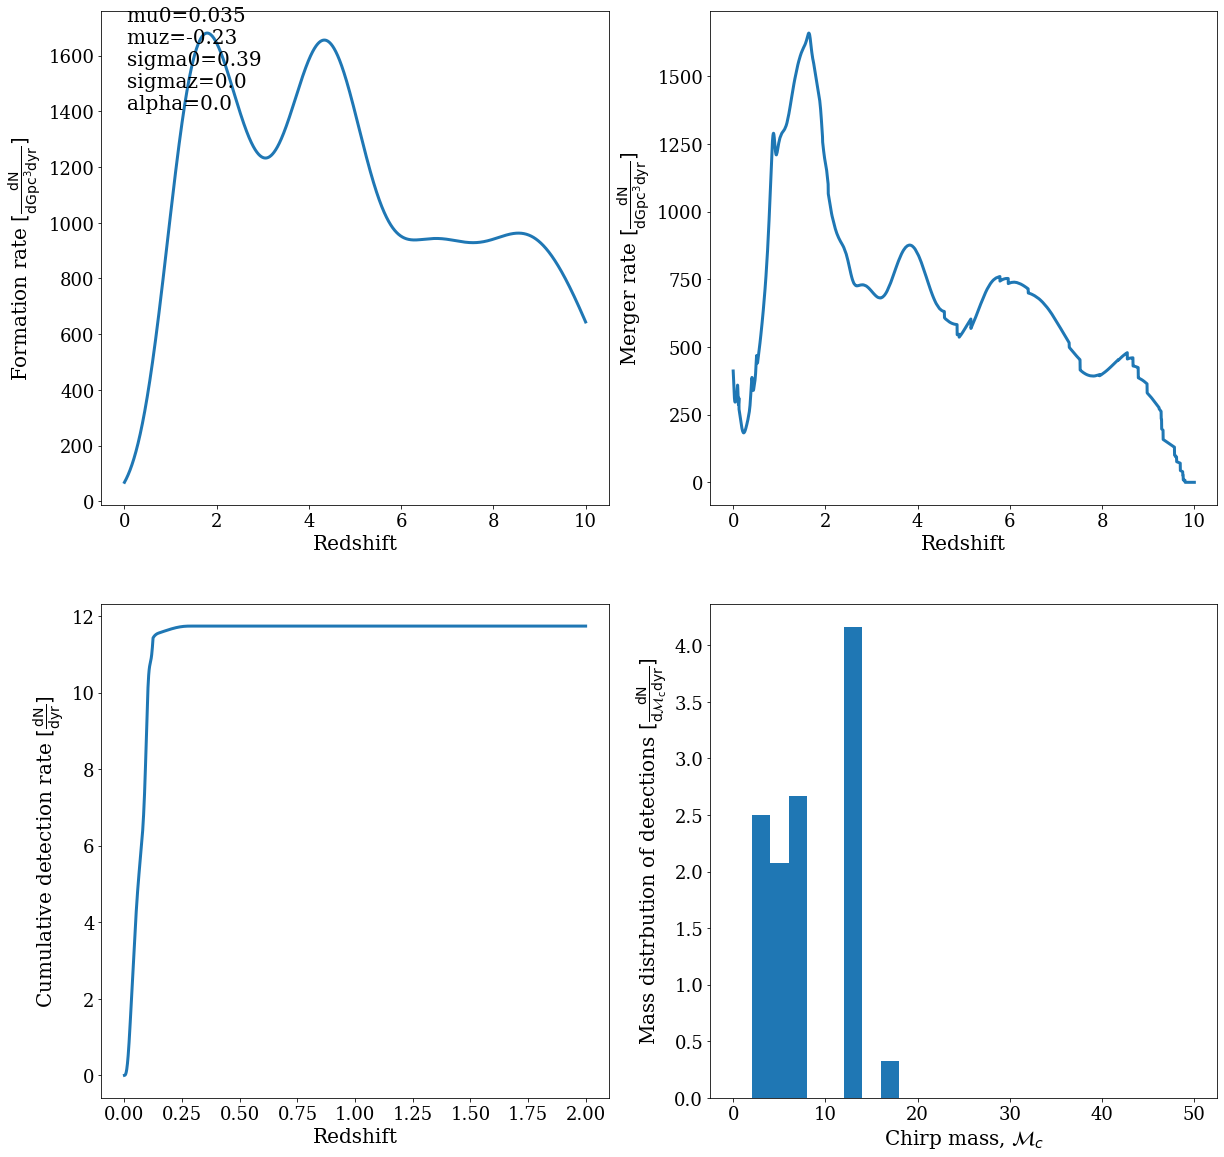

In [13]:
###########################
#Start plotting

# set some constants for the plots
plt.rc('font', family='serif')
fs = 20
lw = 3

fig, axes = plt.subplots(2, 2, figsize=(20, 20))

axes[0,0].plot(mm_redshifts, mm_total_formation_rate, lw=lw)
axes[0,0].set_xlabel('Redshift', fontsize=fs)
axes[0,0].set_ylabel(r'Formation rate $[\rm \frac{\mathrm{d}N}{\mathrm{d}Gpc^3 \mathrm{d}yr}]$', fontsize=fs)

axes[0,1].plot(mm_redshifts, mm_total_merger_rate, lw=lw)
axes[0,1].set_xlabel('Redshift', fontsize=fs)
axes[0,1].set_ylabel(r'Merger rate $[\rm \frac{\mathrm{d}N}{\mathrm{d}Gpc^3 \mathrm{d}yr}]$', fontsize=fs)

axes[1,0].plot(mm_redshifts[:len(mm_cumulative_detection_rate)], mm_cumulative_detection_rate, lw=lw)
axes[1,0].set_xlabel('Redshift', fontsize=fs)
axes[1,0].set_ylabel(r'Cumulative detection rate $[\rm \frac{\mathrm{d}N}{\mathrm{d}yr}]$', fontsize=fs)

axes[1,1].hist(mm_chirp_masses, weights=mm_detection_rate_by_binary, bins=25, range=(0, 50))
axes[1,1].set_xlabel(r'Chirp mass, $\mathcal{M}_c$', fontsize=fs)
axes[1,1].set_ylabel(r'Mass distrbution of detections $[\rm \frac{\mathrm{d}N}{\mathrm{d}\mathcal{M}_c \mathrm{d}yr}]$', fontsize=fs)

#########################
#Plotvalues

# Add text upper left corner
axes[0,0].text(0.05,0.8, 
        "mu0={} \nmuz={} \nsigma0={} \nsigmaz={} \nalpha={}".format(mu0,muz,sigma0,sigmaz,alpha), 
        transform=axes[0,0].transAxes, size = fs) 

for ax in axes.flatten():
    ax.tick_params(labelsize=0.9*fs)

# Save and show :)
# plt.savefig(imageDir + "RateInfoHist_mu0{}_muz{}_alpha{}_sigma0{}_sigmaz{}.png".format(mu0, muz, alpha, sigma0, sigmaz), bbox_inches='tight') 
            

In [18]:
print("Hobbs Merger Rate:", hobbs_total_merger_rate[0])
print("MULLERMANDELMerger Rate:", mm_total_merger_rate[0])

Hobbs Merger Rate: 28.197967390090238
MULLERMANDELMerger Rate: 411.106129815803


In [17]:
print(len(hobbs_chirp_masses))
print(len(mm_chirp_masses))

17024
32256


# Get error bars

In [19]:
# get error bars via bootstrapping

# Period-Eccentricity Distribution

In [25]:
hobbs_fdata = h5.File(hobbs_pathData, 'r')
hobbs_ecc = hobbs_fdata['BSE_Double_Compact_Objects']["Eccentricity@DCO"][()]
hobbs_sma = hobbs_fdata['BSE_Double_Compact_Objects']["SemiMajorAxis@DCO"][()]
hobbs_fdata.close()

In [31]:
mm_fdata = h5.File(mm_pathData, 'r')
mm_ecc = mm_fdata['BSE_Double_Compact_Objects']["Eccentricity@DCO"][()]
mm_sma = mm_fdata['BSE_Double_Compact_Objects']["SemiMajorAxis@DCO"][()]
mm_fdata.close()

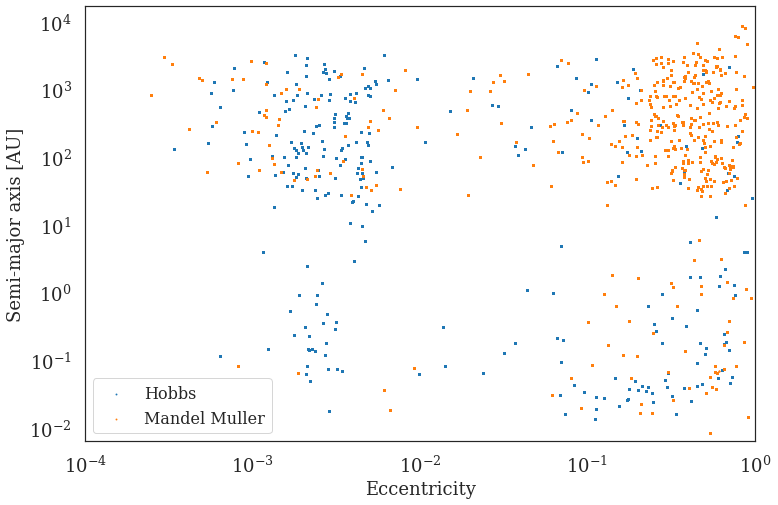

In [50]:
f, ax= plt.subplots(1, 1,  figsize=(12,8)) 

ms=0.8


layoutAxes(ax=ax, nameX='Eccentricity',\
           nameY='Semi-major axis [AU]')

plt.scatter(hobbs_ecc, hobbs_sma, s=ms, label='Hobbs')
plt.scatter(mm_ecc, mm_sma, s=ms, label='Mandel Muller')


plt.legend(fontsize=fs)
    
plt.loglog()
plt.xlim(1e-4, 1e0)

plt.show()
